In [1]:
%matplotlib inline

In [2]:
#!/bin/env python

# -*-coding:utf8-*-

import os
import sys
import logging
import time
import cPickle as pickle

# scipy
from scipy.stats import chi2
import healpy as hp
import numpy as np
import numpy.lib.recfunctions
from argparse import ArgumentParser

# skylab
from skylab.ps_llh import MultiPointSourceLLH
from skylab.llh_models  import EnergyLLH
from skylab.ps_llh import PointSourceLLH
from skylab.ps_injector import PriorInjector
from skylab.datasets import Datasets
from skylab.priors import SpatialPrior

# vector calculations
from astropy.coordinates import UnitSphericalRepresentation
from astropy.coordinates import Angle
from astropy import units as u


# stuff
import getpass
username = getpass.getuser()

import matplotlib.pyplot as plt

Could not import from icecube, coordinate operations will not be possible


In [3]:
def skymap(plt, vals, **kwargs):
    fig, ax = plt.subplots(subplot_kw=dict(projection="aitoff"))
    gridsize = 1000

    x = np.linspace(np.pi, -np.pi, 2 * gridsize)
    y = np.linspace(np.pi, 0., gridsize)

    X, Y = np.meshgrid(x, y)

    r = hp.rotator.Rotator(rot=(-180., 0., 0.))

    YY, XX = r(Y.ravel(), X.ravel())

    pix = hp.ang2pix(hp.npix2nside(len(vals)), YY, XX)

    Z = np.reshape(vals[pix], X.shape)

    lon = x[::-1]
    lat = np.pi /2.  - y

    cb = kwargs.pop("colorbar", dict())
    plot_cb = kwargs.pop("plot_cb", True)
    cb.setdefault("orientation", "horizontal")
    cb.setdefault("fraction", 0.075)

    title = cb.pop("title", None)

    p = ax.pcolormesh(lon, lat, Z, **kwargs)
    plt.hlines(np.radians(-5.), -np.pi, np.pi, 
               color="gray", alpha=0.75, linestyle="--", lw=1)

    cbar = fig.colorbar(p, **cb)
    cbar.solids.set_edgecolor("face")
    cbar.update_ticks()
    if title is not None:
        cbar.set_label(title)
    if not plot_cb: cbar.remove()
    ax.xaxis.set_ticks([])
    plt.text(0,0, r"$180^\circ$", horizontalalignment='center')
    plt.text(np.pi+0.1, 0, r"$0^\circ$", horizontalalignment='left')

    return fig, ax


def make_array_1d(array):
    array = np.atleast_1d(array)
    array = array.flatten()
    return array

def generate_prior_maps(ra, dec, sigma, nside):
    """
    Make simple 2D priors
    """
    assert(ra.shape==dec.shape)
    assert(ra.shape==sigma.shape)
    ra = make_array_1d(ra)
    dec = make_array_1d(dec)
    sigma = make_array_1d(sigma)
    
    theta_map, ra_map = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
    dec_map = np.pi/2. - theta_map

    prior_maps = np.empty((len(ra), hp.nside2npix(nside)), dtype=np.float)

    for i in range(len(ra)):
        mean_vec = UnitSphericalRepresentation(Angle(ra[i], u.radian), 
                                               Angle(dec[i], u.radian))
        map_vec = UnitSphericalRepresentation(Angle(ra_map, u.radian),
                                              Angle(dec_map, u.radian))

        prior_maps[i] = np.exp(-1.*np.power((map_vec-mean_vec).norm(), 2) / sigma[i]**2 / 2.)
    return prior_maps

In [4]:
label = dict(TS=r"$\mathcal{TS}$",
             nsources=r"$n_S$",
             gamma=r"$\gamma$",
             )

In [54]:
args = {
"nsideparam": 4,
"mean_signal": 1,
"gamma": 2.19,
"niter": 1,
"savefigs": False,
"test": True,
"psize": 0.1,
"north_range": [-5., 85.],
"south_range": [-85., -5.]   
}
                             

In [55]:
identifier = "test"
seed = 1
if username=="lschumacher":
    figurepath = "/home/lschumacher/public_html/uhecr_stacking/hotspot_fit/test_plots/"
    savepath = "/data/user/lschumacher/projects/stacking/hotspot_fitting/"
print "Data will be saved to: ", savepath
print "With Identifier: ", identifier

hemispheres = dict(North = np.radians(args["north_range"]), 
                   South = np.radians(args["south_range"]))
sinDec_range =  [-1., 1.]
nside = 2**args["nsideparam"]

Data will be saved to:  /data/user/lschumacher/projects/stacking/hotspot_fitting/
With Identifier:  test


In [56]:
exp, mc, livetime = Datasets['PointSourceTracks'].season("IC86, 2012")
# choose a 10% subset to reduce computing time
if args["test"]:
    rs = np.random.RandomState(seed)
    mc = rs.choice(mc, len(mc)/10)
# use dicts if you want to test multi-year
exps = {1:exp, 0:exp}
mcs = {1:mc, 0:mc}
livetimes = {1:livetime, 0:livetime}

pix = np.array([50, 250, 500, 750])*((nside*1./8)**2)
pix = np.array(pix, dtype=np.int)
theta, ra = hp.pix2ang(nside, pix)
theta = np.concatenate([theta, [np.radians(94.5)]]) # add one pixel right at the horizon
ra = np.concatenate([ra, [np.pi]])
dec = np.pi/2. - theta
sigma = np.full_like(ra, fill_value=np.radians(args["psize"]))
p = generate_prior_maps(ra, dec, sigma, nside)
prior = SpatialPrior(p)

In [57]:
prior.p.sum()*prior.pixel_area

5.0

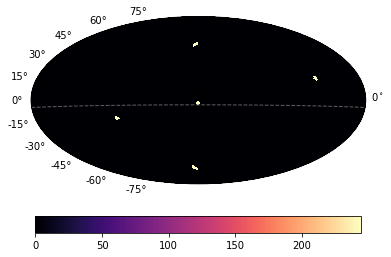

In [58]:
fig, ax = skymap(plt, prior.p.sum(axis=0), cmap=cmap,
                       rasterized=True)

In [59]:
print("\n prior injector setup:")
t0 = time.time()
injector = PriorInjector(prior, gamma=args["gamma"], seed=seed)
injector.fill(exp, mc, livetime)
print("  - took %.2f sec" % (time.time()-t0))
print("raw_flux conversion factor: {:1.2e}".format(injector._raw_flux))


 prior injector setup:
  - took 2.78 sec
raw_flux conversion factor: 2.37e+07


In [60]:
sinDec_bins = np.linspace(-1.0, 1.0, 50+1) # 50 sinDec bins
energy_bins = np.linspace(1., 9., 12+1) # 12 energy bins in log10(E/GeV)
                                           # steps of 0.25 (quarter-decade)
llh_model = EnergyLLH(twodim_bins = [energy_bins, sinDec_bins])
llh = PointSourceLLH(exp, mc, livetime, llh_model, mode="box")

In [61]:
for i,(scan, hotspot) in enumerate(llh.do_allsky_trials(args["niter"], 
                              injector=injector,
                              mean_signal=args["mean_signal"]*len(prior.p),
                              poisson=False,
                              return_position=args["mean_signal"]>0,
                              nside=nside,
                              hemispheres=hemispheres,
                              spatial_prior=prior
                             )):
    print "blubb ", i

blubb  0


In [42]:
hotspot.keys()

['spatial_prior_4',
 'spatial_prior_3',
 'spatial_prior_2',
 'spatial_prior_1',
 'spatial_prior_0',
 'dec_inj',
 'ra_inj']

In [66]:
pkeys = ['spatial_prior_0', 'spatial_prior_1', 'spatial_prior_2']#, 'spatial_prior_3', 'spatial_prior_4']

for i,p in enumerate(pkeys):
    print(hotspot[p]['best']['ra'])
    print(hotspot[p]['fit']['ra'])
    #print(hotspot['ra_inj'][i])
    print(hotspot[p]['best']['dec'])
    print(hotspot[p]['fit']['dec'])
    #print(hotspot['dec_inj'][i])
    print("* *"*5)
    

3.125348597887989
3.125348597887989
-0.04277824824142345
-0.04277824824142345
* ** ** ** ** *
3.125348597887989
3.125348597887989
-0.04277824824142345
-0.04277824824142345
* ** ** ** ** *
3.125348597887989
3.125348597887989
-0.04277824824142345
-0.04277824824142345
* ** ** ** ** *


In [43]:
pkeys = ['spatial_prior_0', 'spatial_prior_1', 'spatial_prior_2']#, 'spatial_prior_3', 'spatial_prior_4']

for i,p in enumerate(pkeys):
    print(hotspot[p]['best']['ra'])
    print(hotspot['ra_inj'][i])
    print("")
    print(hotspot[p]['best']['dec'])
    print(hotspot['dec_inj'][i])
    print("* *"*5)
    

3.2397674240144743
2.879793265790644

0.05210690963834175
1.1073814549606387
* ** ** ** ** *
3.2397674240144743
0.8344855486097889

0.05210690963834175
0.1674480792196893
* ** ** ** ** *
3.2397674240144743
4.957825906446392

0.05210690963834175
-0.33983690945412204
* ** ** ** ** *


In [44]:
"""
for k in scan.dtype.names:
        scan[k] = hp.sphtfunc.smoothing(scan[k], sigma=np.radians(0.5))
"""
eps = 1.

if hasattr(plt.cm, "magma"):
    cmap = plt.cm.magma
else:
    cmap = None

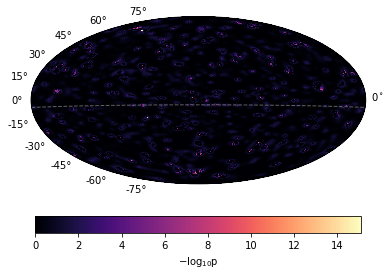

In [45]:
fig, ax = skymap(plt, scan["pVal"], cmap=cmap,
                       #vmin=0., 
                       colorbar=dict(title=r"$-\log_{10}\rm p$"),
                       rasterized=True)
    

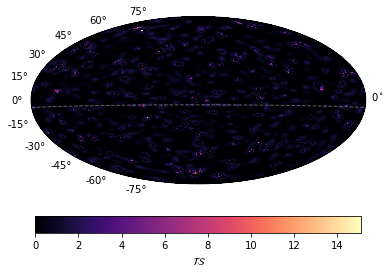

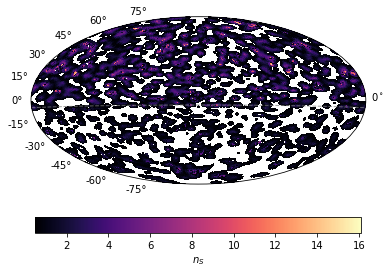

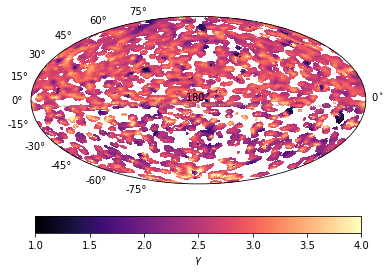

In [46]:
for key in ["TS"] + llh.params:
    eps = 0.1 if key != "TS" else 0.0
    vmin, vmax = np.percentile(scan[key], [eps, 100. - eps])
    vmin = np.floor(max(0, vmin))
    vmax = min(8, np.ceil(vmax))
    q = np.ma.masked_array(scan[key])
    q.mask = ~(scan["nsources"] > 0.5) if key != "TS" else np.zeros_like(q, dtype=np.bool)
    fig, ax = skymap(plt, q, cmap=cmap,
                           #vmin=vmin, vmax=vmax,
                           colorbar=dict(title=label[key]),
                           rasterized=True)
    